In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33833")
client

<Client: 'tcp://127.0.0.1:33833' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:34399' processes=4 threads=32, memory=117.98 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [6]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()

istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)

llc01w = model.get_dataset(varnames=['Theta'], 
#                            k_levels=[0],
                           k_levels=list(range(52)),
#                            iters=list(iters),
                           iters=[istart],
                           type='latlon'
                          ).sel(j=slice(9555,10198),j_g=slice(9555,10198),
                                i=slice(15355,15845),i_g=slice(15355,15845)
                               )

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llc01w, periodic=[],
               coords={
                       'Z':{'center':'k','outer':'k_p1','left':'k_l'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )

In [1]:
import fsspec
url = "https://data.nas.nasa.gov/ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000154224/Eta.0000154224.data.shrunk"
with fsspec.open(url, mode='rb') as fp:
    # test size works
    assert fp.size == 562551864
with fsspec.open(url, mode='rb') as fp:
    # test seek works
    fp.seek(2)

In [ ]:
months = {'aug':['2011-08-01','2011-08-31'],
          'sep':['2011-09-01','2011-09-30'],
          'oct':['2011-10-01','2011-10-31'],
          'feb':['2012-02-01','2012-02-29'],
          'mar':['2012-03-01','2012-03-31'],
          'apr':['2012-04-01','2012-04-30']}

gcs = gcsfs.GCSFileSystem(requester_pays=True)

mstart = 3
for month in list(months.keys())[mstart:]:
    
    dates = pd.date_range(months[month][0],months[month][1],freq='D')
    
    for dd in range(len(dates)):
        tmp_path = f'{SCRATCH}/region01/LLC4320/'+str(month)+f'/W_'+("%02d" % dates[dd].day)+f'.zarr'
        

        if month == 'feb' and dd == 0:
            ww = xr.open_zarr(gcs.get_mapper(tmp_path)).W
        else:
            ww = xr.concat([ww, xr.open_zarr(gcs.get_mapper(tmp_path)).W
                           ], 'time')
ww.coords['time'] = ('time',pd.date_range(months['feb'][0],months['apr'][1],freq='D'))

In [7]:
grav = 9.81
w_path = f'{SCRATCH}/region01/LLC4320/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0

bw = -sig0w * grav / 1e3

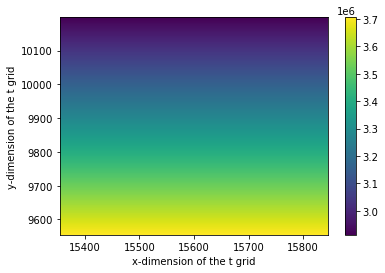

In [8]:
area = (llc01w.dyF * llc01w.dxF).reset_coords(drop=True)
area.plot()

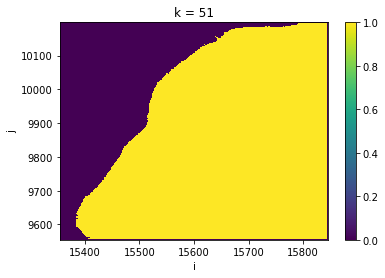

In [9]:
mask = ~np.ma.masked_invalid(sig0w.isel(time=0)).mask

pad = 1
xrmask = xr.DataArray(mask.astype(np.float64), dims=sig0w.isel(time=0).dims,
                      coords=sig0w.isel(time=0).coords
                     ).reset_coords(drop=True)
mask[:,:1,:] = 0.
mask[:,-1:,:] = 0.
mask[:,:,:1] = 0.
mask[:,:,-1:] = 0.
wet_mask = xr.DataArray(mask.astype(np.float64), dims=sig0w.isel(time=0).dims,
                        coords=sig0w.isel(time=0).coords
                       ).reset_coords(drop=True)

wet_mask.isel(k=-1).plot()

In [11]:
dxw = xr.DataArray(llc01w.dxC.data,  # x-spacing centered at western cell edge
                   dims=['j','i'], 
                   coords=wet_mask.isel(k=0).coords
                  ).reset_coords(drop=True)

dyw = xr.DataArray(llc01w.dyG.data,  # y-spacing centered at western cell edge
                   dims=['j','i'],
                   coords=wet_mask.isel(k=0).coords
                  ).reset_coords(drop=True)

dxs = xr.DataArray(llc01w.dxG.data,  # x-spacing centered at southern cell edge
                   dims=['j','i'],
                   coords=wet_mask.isel(k=0).coords
                  ).reset_coords(drop=True)

dys = xr.DataArray(llc01w.dyC.data,  # y-spacing centered at southern cell edge
                   dims=['j','i'],
                   coords=wet_mask.isel(k=0).coords
                  ).reset_coords(drop=True)

In [12]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(1642.2244, dtype=float32)

In [13]:
kappa_w = xr.ones_like(wet_mask)

kappa_s = xr.ones_like(wet_mask)

In [14]:
filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'j':-1,'i':-1}), 
        'dxw': dxw.chunk({'j':-1,'i':-1}), 'dyw': dyw.chunk({'j':-1,'i':-1}), 
        'dxs': dxs.chunk({'j':-1,'i':-1}), 'dys': dys.chunk({'j':-1,'i':-1}), 
        'area': area.chunk({'j':-1,'i':-1}), 
        'kappa_w': kappa_w.chunk({'j':-1,'i':-1}), 
        'kappa_s': kappa_s.chunk({'j':-1,'i':-1})
    }
)

In [15]:
bm = filter_30km.apply(bw.chunk({'j':-1,'i':-1}), dims=['j', 'i'])

In [10]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/MLD_fma.zarr")).MLD
MLDw

<xarray.DataArray 'MLD' (time: 90, j: 644, i: 491)>
dask.array<open_dataset-4d7267ffca0977a18eed80fd66bfb602MLD, shape=(90, 644, 491), dtype=float64, chunksize=(10, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 15355 15356 15357 15358 15359 ... 15842 15843 15844 15845
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10195 10196 10197 10198
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

In [11]:
ncoars = 4

In [25]:
MLDw_coar = ((MLDw*area).isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                                  boundary='trim').sum(skipna=True)
             * area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                             boundary='trim').sum(skipna=True)**-1
            )

In [28]:
dbmx = gridllc.diff(gridllc.interp(bm,'X',boundary='extend'), 'X', boundary='extend') / llc01w.dxF
dbmy = gridllc.diff(gridllc.interp(bm,'Y',boundary='extend'), 'Y', boundary='extend') / llc01w.dyF

M2 = np.sqrt(dbmx.isel(j=slice(1,-1),i=slice(1,-1))**2 
             + dbmy.isel(j=slice(1,-1),i=slice(1,-1))**2
            ).reset_coords(drop=True)
print(M2)

<xarray.DataArray (time: 90, k: 52, j: 642, i: 489)>
dask.array<sqrt, shape=(90, 52, 642, 489), dtype=float64, chunksize=(1, 10, 642, 489), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50 51
  * j        (j) int64 9556 9557 9558 9559 9560 ... 10194 10195 10196 10197
  * i        (i) int64 15356 15357 15358 15359 15360 ... 15841 15842 15843 15844


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

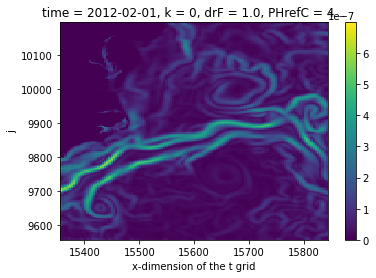

In [53]:
dbmx_coar = ((dbmx.isel(j=slice(1,-1))
              *area.isel(j=slice(1,-1),i=slice(1,-1))).coarsen({'j':ncoars,'i':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
dbmy_coar = ((dbmy.isel(i=slice(1,-1))
              *area.isel(j=slice(1,-1),i=slice(1,-1))).coarsen({'j':ncoars,'i':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
M2_coar = ((M2.where(llc01w.Z>=MLDw.isel(j=slice(1,-1),i=slice(1,-1)))
            * area.isel(j=slice(1,-1),i=slice(1,-1))).coarsen({'j':ncoars,'i':ncoars},
                                                           boundary='trim').sum(skipna=True)
           * area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )
M2_coar.isel(time=0,k=0).plot()

In [54]:
dbmy_coarH = (dbmy_coar
              * llc01w.drF.where(llc01w.Z>=MLDw).isel(j=slice(1,-1),i=slice(1,-1)
                                                ).coarsen({'j':ncoars,'i':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('k', skipna=True)
dbmx_coarH = (dbmx_coar
              * llc01w.drF.where(llc01w.Z>=MLDw).isel(j=slice(1,-1),i=slice(1,-1)
                                                ).coarsen({'j':ncoars,'i':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('k', skipna=True)
M2_coarH = (M2_coar 
            * llc01w.drF.where(llc01w.Z>=MLDw).isel(j=slice(1,-1),i=slice(1,-1)
                                                ).coarsen({'j':ncoars,'i':ncoars},
                                    boundary='trim').mean(skipna=True)
           ).sum('k', skipna=True)
M2_coarH

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


,Array,Chunk
Bytes,13.40 MiB,19.53 kiB
Shape,"(90, 160, 122)","(1, 50, 50)"
Count,278772 Tasks,1080 Chunks
Type,float64,numpy.ndarray


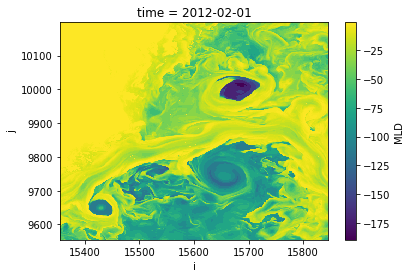

In [52]:
MLDw.isel(time=0).plot()

In [55]:
M2_coarb = (M2_coarH 
            / xr.DataArray(e3t.where(e3t.deptht>=MLDw).isel(y=slice(1,-1),x=slice(1,-1))
                          ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True).sum('deptht',skipna=True)
           )
M2_coarb

<xarray.DataArray (time_counter: 89, y: 152, x: 121)>
dask.array<truediv, shape=(89, 152, 121), dtype=float64, chunksize=(3, 15, 32), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * y             (y) float64 4.0 9.0 14.0 19.0 24.0 ... 744.0 749.0 754.0 759.0
  * x             (x) float64 4.0 9.0 14.0 19.0 24.0 ... 589.0 594.0 599.0 604.0
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
    depth         (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1f           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    ...            ...
    e2u           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e2v           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>

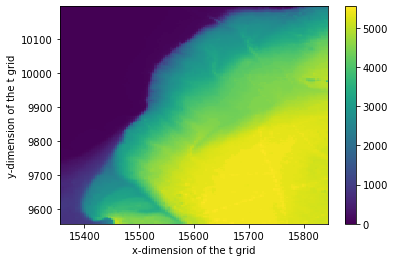

In [12]:
import gsw
f = gsw.f(llc01w.YC.where(xrmask[0]!=0.).isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                         boundary='trim').mean(skipna=True)
         )
depth_coar = ((llc01w.Depth.isel(j=slice(1,-1),i=slice(1,-1))
               * area.isel(j=slice(1,-1),i=slice(1,-1))).coarsen({'j':ncoars,'i':ncoars},boundary='trim').sum() 
              / area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},boundary='trim').sum() 
             )
depth_coar.plot()

In [ ]:
tmp_path = f'{SCRATCH}/region01/LLC4320/'+f'MLI-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
(M2_coarH**2 / f).where(depth_coar>1e2).reset_coords(drop=True).chunk({'time':10,'j':-1,'i':-1}).to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

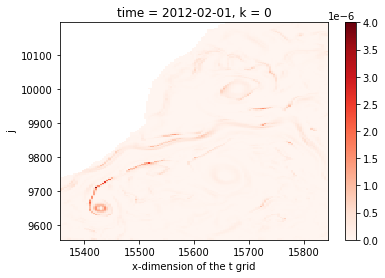

In [55]:
(M2_coarH**2
 / f).isel(time=0).where(depth_coar>1e2).plot(cmap='Reds', vmin=0, vmax=4e-6)

In [25]:
sig0b = xr.apply_ufunc(gsw.sigma0, s_b, t_b,
                       dask='parallelized', output_dtypes=[float,]
                      )
z10 = 6   # grid index of ~10m depth
nMLDb = z10 + np.abs((sig0b.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0b.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLD_b = (xr.ones_like(sig0b.isel(deptht=slice(None,-1))) 
         * enatl01w.deptht).reset_coords(drop=True)[{'deptht':nMLDb}] 

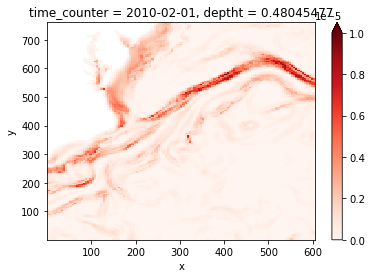

In [64]:
(M2_coarH**2
 / f * boost).isel(time_counter=0).plot(cmap='Reds', vmin=0, vmax=1e-5)

In [13]:
MLI = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/MLI-30km_z0-MLD_fma.zarr")).MLI

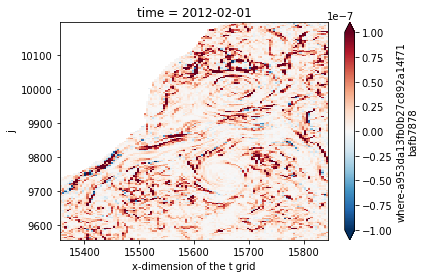

In [14]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/wb-30km_z0-MLD_fma.zarr")).wpbp
wpbp_coar = xr.DataArray(((wpbp * area.isel(j=slice(1,-1),i=slice(1,-1))).coarsen({'j':ncoars,'i':ncoars},
                                                                                  boundary='trim').sum(skipna=True)
                          * area.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                                           boundary='trim').sum(skipna=True)**-1
).where(depth_coar>1e2).data, dims=MLI.dims, coords=MLI.coords)

wpbp_coar.isel(time=0).plot(cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

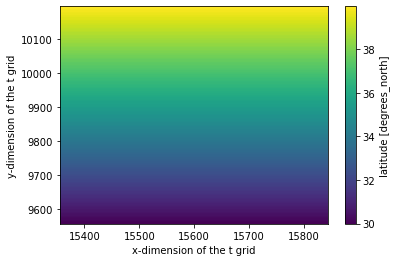

In [17]:
lat_coar = llc01w.YC.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                               boundary='trim').mean(skipna=True).reset_coords(drop=True)
lon_coar = llc01w.XC.isel(j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                               boundary='trim').mean(skipna=True).reset_coords(drop=True)
lat_coar.plot()

In [19]:
mask_coar = xrmask.isel(k=0,j=slice(1,-1),i=slice(1,-1)).coarsen({'j':ncoars,'i':ncoars},
                                                                 boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask_coar = ~np.ma.masked_values(mask_coar,0).mask
mask_coar

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [15]:
Ce = (wpbp_coar.reset_coords(drop=True).data / MLI).compute()
Ce.name = 'Ce'
Ce

<xarray.DataArray 'Ce' (time: 90, j: 160, i: 122)>
array([[[ 4.03181534e-01,  2.77934489e-01,  1.50533998e-01, ...,
         -6.46924683e-01,  9.65009301e-02,  9.73867737e-01],
        [ 7.42472710e-01,  1.33721536e+00,  1.35520337e+00, ...,
          2.33377715e-01,  3.81409558e-01, -1.02688009e+00],
        [ 1.64932773e-01,  1.37144601e-02,  7.36879814e-03, ...,
         -9.84252205e-02, -3.80744863e-01,  5.31314361e-01],
        ...,
        [            nan,             nan,             nan, ...,
         -2.49695108e-01,  1.30057177e+00, -7.16025714e-01],
        [            nan,             nan,             nan, ...,
         -3.41921803e-02, -2.22477047e-01,  4.51250647e-01],
        [            nan,             nan,             nan, ...,
         -2.39458807e-03, -3.08247406e-01,  6.47189252e-01]],

       [[ 1.92507320e-01,  1.04383432e+00,  2.57389776e-01, ...,
          1.78691315e-01,  4.59636030e-01, -6.79079526e-02],
        [ 1.10937592e+00,  8.96055117e-01,  2.32661686e+00, ...,
          1.02783290e+00, -4.41666588e-01, -5.26368381e-01],
        [ 9.45156135e+00,  3.63207876e+00,  8.86283879e-01, ...,
         -1.16768623e-01,  5.66990398e-01,  2.36889944e-01],
...
        [            nan,             nan,             nan, ...,
         -1.82403491e+01,  7.91926756e-01,  1.07441204e+01],
        [            nan,             nan,             nan, ...,
          4.96339653e+00,  5.42753051e+00,  1.72281870e+01],
        [            nan,             nan,             nan, ...,
          1.90066216e+01,  2.21373661e+01,  8.05871653e+00]],

       [[ 1.41584665e+00,  4.95697859e+00,  1.05546733e+00, ...,
         -5.09754797e-01, -2.27367060e+00,  2.98691458e-01],
        [ 2.71968212e+00, -3.66756924e+00, -4.95413534e+00, ...,
         -9.45136890e-01, -2.75233733e+00, -2.90775856e+00],
        [ 2.04507446e+00, -3.09528418e+00,  1.90262881e+00, ...,
          3.37303062e+00,  2.66409467e+00,  6.01765748e-01],
        ...,
        [            nan,             nan,             nan, ...,
         -1.75028447e+02,  1.77606893e+01,  1.05319984e+01],
        [            nan,             nan,             nan, ...,
         -8.31003766e+00, -2.03930563e+00,  1.16806847e+00],
        [            nan,             nan,             nan, ...,
         -2.59438456e+00,  4.16819274e+00, -7.73378032e+00]]])
Coordinates:
  * i        (i) float64 1.536e+04 1.536e+04 1.537e+04 ... 1.584e+04 1.584e+04
  * j        (j) int64 9558 9562 9566 9570 9574 ... 10182 10186 10190 10194
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30

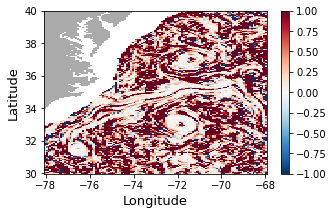

In [21]:
fig, ax = plt.subplots(figsize=(5,3))

im = ax.pcolormesh(lon_coar, lat_coar, Ce.isel(time=0), 
                   vmin=-1, vmax=1, cmap='RdBu_r', shading='auto', rasterized=True)

ax.pcolormesh(lon_coar, lat_coar, np.ma.masked_array(mask_coar, mask_coar),
              vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=13)
ax.set_ylabel(r"Latitude", fontsize=13)
fig.colorbar(im, ax=ax)

plt.savefig('/home/jovyan/Figures/LLC4320-Ce_01.pdf')

In [42]:
alpha = (Ce).median(['j','i'],skipna=True).compute()

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar.name = 'wpbp'

In [18]:
time = np.arange('2012-02', '2012-05', dtype='datetime64[D]')
time

array(['2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04',
       '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
       '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12',
       '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16',
       '2012-02-17', '2012-02-18', '2012-02-19', '2012-02-20',
       '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24',
       '2012-02-25', '2012-02-26', '2012-02-27', '2012-02-28',
       '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03',
       '2012-03-04', '2012-03-05', '2012-03-06', '2012-03-07',
       '2012-03-08', '2012-03-09', '2012-03-10', '2012-03-11',
       '2012-03-12', '2012-03-13', '2012-03-14', '2012-03-15',
       '2012-03-16', '2012-03-17', '2012-03-18', '2012-03-19',
       '2012-03-20', '2012-03-21', '2012-03-22', '2012-03-23',
       '2012-03-24', '2012-03-25', '2012-03-26', '2012-03-27',
       '2012-03-28', '2012-03-29', '2012-03-30', '2012-03-31',
       '2012-04-01', '2012-04-02', '2012-04-03', '2012-

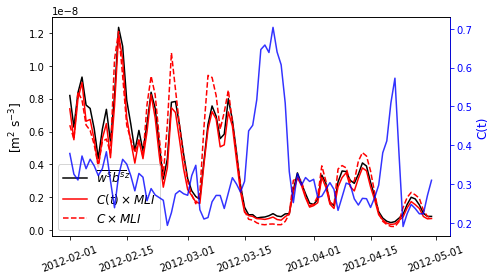

In [64]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['j','i'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['j','i'],skipna=True), c='r', label=r'$C(t) \times MLI$')
ax.plot(time, (alpha.mean('time')*MLI).median(['j','i'],skipna=True), c='r', ls='--', label=r'$C \times MLI$')

ax2.plot(time, alpha, c='b', alpha=.8)

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2012-02-01','2012-02-15','2012-03-01','2012-03-15','2012-04-01',
               '2012-04-15','2012-05-01'])
ax.set_xticklabels(labels=['2012-02-01','2012-02-15','2012-03-01','2012-03-15',
                           '2012-04-01','2012-04-15','2012-05-01'],
                   rotation=20)
ax2.set_ylabel(r"C(t)", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/LLC4320-wb-timeseries_01.pdf')

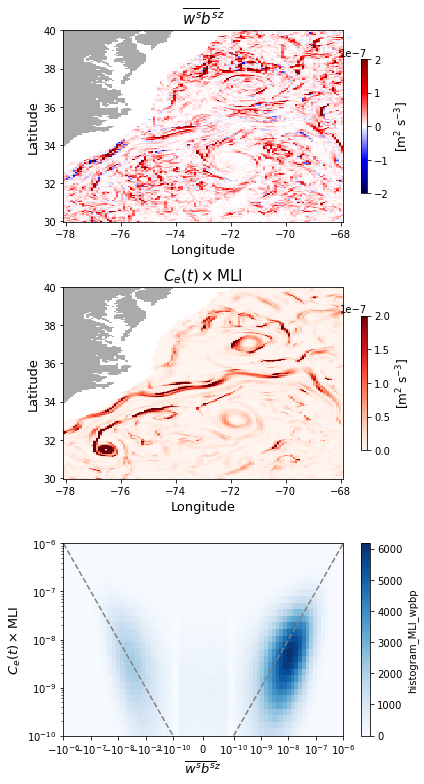

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,11),nrows=3,ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(lon_coar, lat_coar, wpbp_coar.isel(time=0),
                     vmin=-2e-7, vmax=2e-7, cmap='seismic', shading='auto', rasterized=True)
im2 = ax2.pcolormesh(lon_coar, lat_coar, aMLI.isel(time=0),
                     vmin=0., vmax=2e-7, cmap='Reds', shading='auto', rasterized=True)

ax1.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask_coar, mask_coar),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)
ax2.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask_coar, mask_coar),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)

xhist((aMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthresh=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax3.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)
ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_title(r"$C_e(t)\times$MLI", fontsize=15)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/LLC4320-wb-hist_01.pdf')

In [26]:
alpham = (Ce).mean(['j','i'],skipna=True)

amMLI = alpham*MLI
amMLI.name = 'MLI'

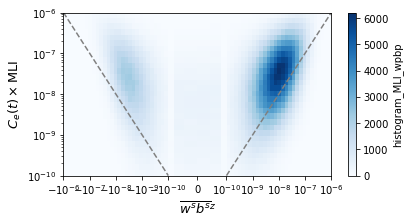

In [29]:
fig, ax = plt.subplots(figsize=(6,3))

xhist((amMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/LLC4320-wb_meanCe-hist_01.pdf')

In [43]:
alpha75 = np.ones(len(MLI.time))
for i in range(len(MLI.time)):
    alpha75[i] = np.quantile(np.ma.masked_invalid((Ce).isel(time=i)).compressed(), 
                             .75
                            )

a75MLI = alpha75[:,np.newaxis,np.newaxis]*MLI
a75MLI.name = 'MLI'

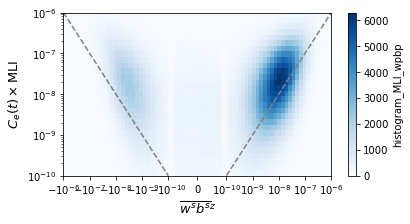

In [44]:
fig, ax = plt.subplots(figsize=(6,3))

xhist((a75MLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/LLC4320-wb_075Ce-hist_01.pdf')

In [61]:
alphamo = np.ones(len(MLI.time))
for i in range(len(MLI.time)):
    histo = xhist(Ce.isel(time=0),
                  bins=[np.logspace(-4,2,50)
                       ]
                 )
    ix = np.argmax(histo.values)
    alphamo[i] = histo.Ce_bin[ix]

amoMLI = alphamo[:,np.newaxis,np.newaxis]*MLI
amoMLI.name = 'MLI'

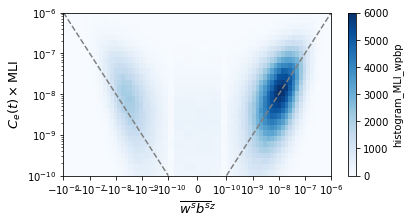

In [62]:
fig, ax = plt.subplots(figsize=(6,3))

xhist((amoMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/LLC4320-wb_modeCe-hist_01.pdf')